In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
from ta import momentum, trend

import time
import copy
import random
import numpy as np
import pandas as pd
import chainer
import chainer.functions as F
import chainer.links as L
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl


from tqdm import tqdm

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

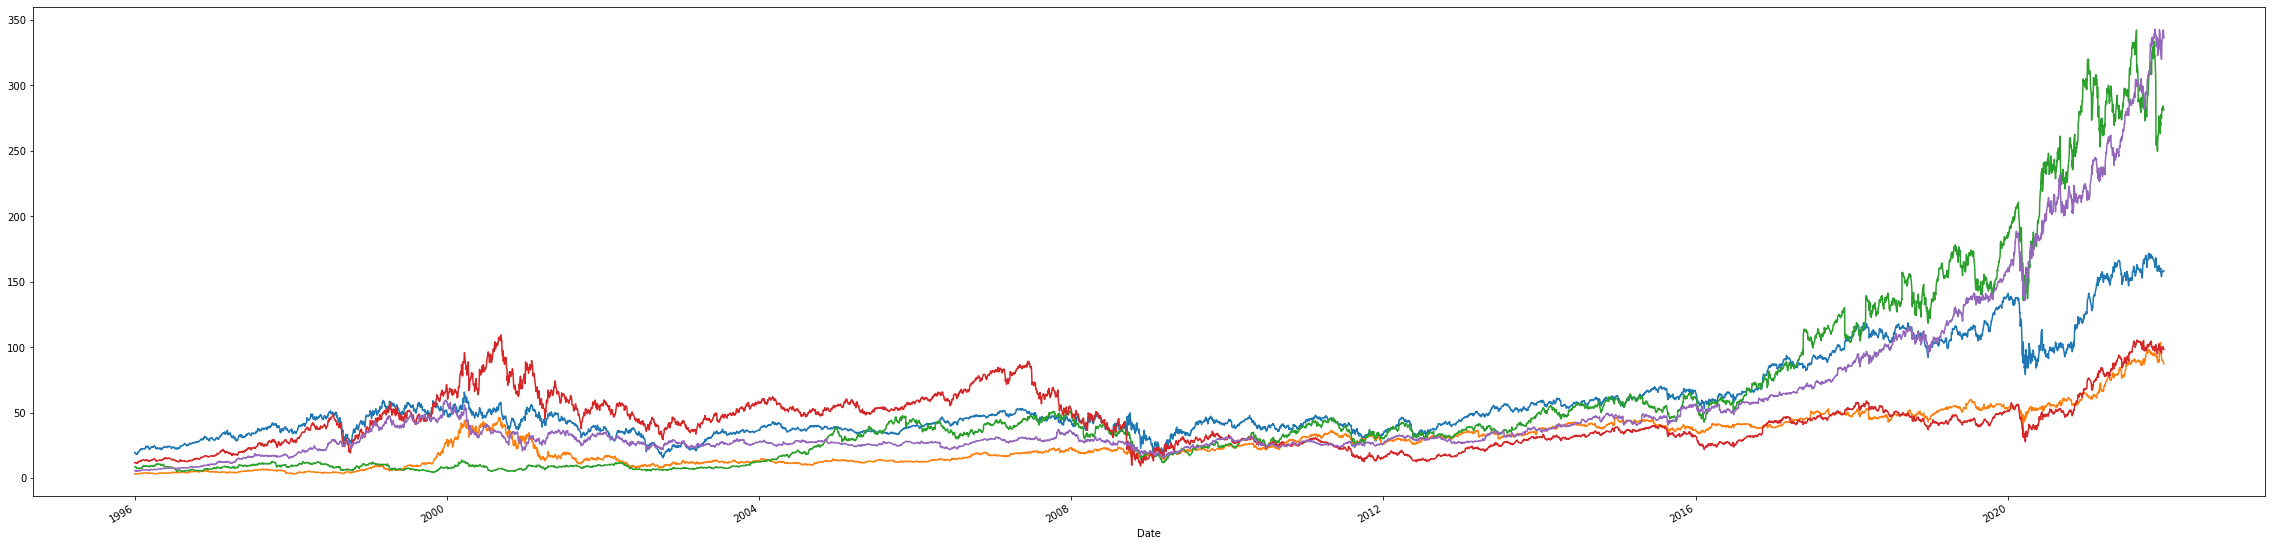

In [14]:
start_date = '1996-01-01'
end_date = '2022-01-01'

data_JPM = yf.download('JPM', start_date, end_date)
data_ORCL = yf.download('ORCL', start_date, end_date)
data_ADSK = yf.download('ADSK', start_date, end_date)
data_MS = yf.download('MS', start_date, end_date)
data_MSFT = yf.download('MSFT', start_date, end_date)


data_JPM['Close'].plot(figsize = (40,10))
data_ORCL['Close'].plot(figsize = (40,10))
data_ADSK['Close'].plot(figsize = (40,10))
data_MS['Close'].plot(figsize = (40,10))
data_MSFT['Close'].plot(figsize = (40,10))

In [15]:
df = [data_JPM, data_ORCL, data_ADSK, data_MS, data_MSFT]

In [16]:
rsi_period = 14
ema_period = 50

for tick in df:
    tick['RSI'] = momentum.RSIIndicator(tick['Close'], rsi_period).rsi()
    tick['EMA'] = trend.EMAIndicator(tick['Close'], window=ema_period).ema_indicator()
    tick['Close_EMA_ratio'] = tick['Close']/tick['EMA']

In [17]:
data_JPM = data_JPM[50:]
data_ORCL = data_ORCL[50:]
data_ADSK = data_ADSK[50:]
data_MS = data_MS[50:]
data_MSFT = data_MSFT[50:]

In [18]:
split_len = int(0.8 * len(data_JPM))
tickers = ['JPM', 'ORCL', 'ADSK', 'MS', 'MSFT']

JPM_train = data_JPM[:split_len]
ORCLS_train = data_ORCL[:split_len]
ADSK_train = data_ADSK[:split_len]
MS_train = data_MS[:split_len]
MSFT_train = data_MSFT[:split_len]

JPM_test = data_JPM[split_len:]
ORCLS_test = data_ORCL[split_len:]
ADSK_test = data_ADSK[split_len:]
MS_test = data_MS[split_len:]
MSFT_test = data_MSFT[split_len:]

In [19]:
df = [
    data_JPM,
    data_ORCL,
    data_ADSK,
    data_MS,
    data_MSFT
]

In [20]:
class Environment:
    
    def __init__(self, df, history_t=50):
        self.df = df
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.data = random.choice(df)
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.capital = 10000
        self.position_value = 0
        self.rsi = 50
        self.cema = 1
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + [self.capital] + [self.rsi] + [self.cema] + self.history # obs
    
    def step(self, act):
        reward = -1
        
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            if self.capital - self.data.iloc[self.t, :]['Close'] < 0:
                reward = -100
            else:
                self.positions.append(self.data.iloc[self.t, :]['Close'])
                self.capital -= self.data.iloc[self.t, :]['Close']
                reward = 2
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -100
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
                self.capital += self.data.iloc[self.t, :]['Close']
        
        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        
        
        # clipping reward
        # if reward > 0:
        #     reward = 1
        # elif reward < 0:
        #     reward = -1
        
        return [self.position_value] + [self.capital] + [self.data['RSI'][self.t]] + [self.data['Close_EMA_ratio'][self.t]] + self.history, reward, self.done # obs, reward, done

In [25]:
def train_dqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc21 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            h = F.relu(self.fc21(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+4, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 70
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-6
    epsilon_min = 0.15
    start_reduce_epsilon = 200000
    train_freq = 100
    update_q_freq = 200
    gamma = 0.97
    show_log_freq = 10

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []
    total_capital = []

    start = time.time()
    for epoch in tqdm(range(epoch_num), desc="Training", unit="epoch"):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        for step in range(step_max):

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

                   

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min:
                epsilon = 1-0.02*epoch

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)
        total_capital.append(env.capital)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\n'.join(map(str, [
                "Epoch: " + str(epoch + 1),
                "Epsilon: " + str(epsilon),
                "Total Steps: " + str(total_step),
                "Reward: " + str(log_reward),
                "Loss: " + str(log_loss),
                "Current Capital: " + str(env.capital),
                "Time Elapsed: " + str(elapsed_time),
            ])))
            start = time.time()
            
    return Q, total_losses, total_rewards

In [26]:
Q, total_losses, total_rewards = train_dqn(Environment(df))

Training:   0%|          | 0/70 [00:00<?, ?epoch/s]/var/folders/yf/zxptpvps4wd81trf6xv52k_40000gn/T/ipykernel_42306/2074788002.py:77: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/var/folders/yf/zxptpvps4wd81trf6xv52k_40000gn/T/ipykernel_42306/2074788002.py:85: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

Training:  14%|█▍        | 10/70 [00:26<02:45,  2.76s/epoch]

Epoch: 10
Epsilon: 0.8200000000000001
Total Steps: 64960
Reward: -238968.56957964896
Loss: 720989.6370685041
Current Capital: 18.4910569190979
Time Elapsed: 26.326176166534424


Training:  29%|██▊       | 20/70 [00:57<02:46,  3.34s/epoch]

Epoch: 20
Epsilon: 0.62
Total Steps: 129920
Reward: -199026.08465998172
Loss: 226070.08979642988
Current Capital: 15.948427200317383
Time Elapsed: 31.54298710823059


Training:  43%|████▎     | 30/70 [01:38<02:48,  4.20s/epoch]

Epoch: 30
Epsilon: 0.42000000000000004
Total Steps: 194880
Reward: -139793.98133704663
Loss: 63884.04539231137
Current Capital: 14.743416786193848
Time Elapsed: 40.53587770462036


Training:  57%|█████▋    | 40/70 [02:25<02:32,  5.07s/epoch]

Epoch: 40
Epsilon: 0.21999999999999997
Total Steps: 259840
Reward: -91664.81282548905
Loss: 53604.68547164686
Current Capital: 68.51218152046204
Time Elapsed: 47.48270893096924


Training:  71%|███████▏  | 50/70 [03:22<01:52,  5.64s/epoch]

Epoch: 50
Epsilon: 0.14
Total Steps: 324800
Reward: -49460.45761516094
Loss: 33880.927098855376
Current Capital: 66.89845752716064
Time Elapsed: 56.33658289909363


Training:  86%|████████▌ | 60/70 [04:23<01:02,  6.23s/epoch]

Epoch: 60
Epsilon: 0.14
Total Steps: 389760
Reward: -50524.39932119846
Loss: 26649.84375795871
Current Capital: 37.85966181755066
Time Elapsed: 61.725077867507935


Training: 100%|██████████| 70/70 [05:21<00:00,  4.60s/epoch]

Epoch: 70
Epsilon: 0.14
Total Steps: 454720
Reward: -47941.34248907566
Loss: 21753.40277247224
Current Capital: 193.93323707580566
Time Elapsed: 57.85367393493652


In [27]:
def plot_loss_reward(total_losses, total_rewards):

    figure = tools.make_subplots(rows=1, cols=2, subplot_titles=('loss', 'reward'), print_grid=False)
    figure.append_trace(Scatter(y=total_losses, mode='lines', line=dict(color='skyblue')), 1, 1)
    figure.append_trace(Scatter(y=total_rewards, mode='lines', line=dict(color='orange')), 1, 2)
    figure['layout']['xaxis1'].update(title='epoch')
    figure['layout']['xaxis2'].update(title='epoch')
    figure['layout'].update(height=600, width=1200, showlegend=False)
    iplot(figure)

plot_loss_reward(total_losses, total_rewards)

/Users/celestiq/tensorflow-ml/ml_env/lib/python3.8/site-packages/plotly/tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [28]:
def plot_train_test_by_q(train_env, test_env, Q, algorithm_name):
    
    # train
    pobs = train_env.reset()
    train_acts = []
    train_rewards = []

    for i in range(len(train_env.data)-1):
        # print(i)
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        train_acts.append(pact)
            
        obs, reward, done = train_env.step(pact)
        train_rewards.append(reward)

        pobs = obs
        
    train_profits = train_env.profits
    
    # print("Testing Data")
    # test
    pobs = test_env.reset()
    test_acts = []
    test_rewards = []

    for _ in range(len(test_env.data)-1):
    
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        test_acts.append(pact)
            
        obs, reward, done = test_env.step(pact)
        test_rewards.append(reward)

        pobs = obs
        
    test_profits = test_env.profits
    
    # plot
    train_copy = train_env.data.copy()
    test_copy = test_env.data.copy()
    train_copy['act'] = train_acts + [np.nan]
    train_copy['reward'] = train_rewards + [np.nan]
    test_copy['act'] = test_acts + [np.nan]
    test_copy['reward'] = test_rewards + [np.nan]
    train0 = train_copy[train_copy['act'] == 0]
    train1 = train_copy[train_copy['act'] == 1]
    train2 = train_copy[train_copy['act'] == 2]
    test0 = test_copy[test_copy['act'] == 0]
    test1 = test_copy[test_copy['act'] == 1]
    test2 = test_copy[test_copy['act'] == 2]
    act_color0, act_color1, act_color2 = 'black', 'green', 'red'

    data1 = [
        Candlestick(x=train0.index, open=train0['Open'], high=train0['High'], low=train0['Low'], close=train0['Close'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=train1.index, open=train1['Open'], high=train1['High'], low=train1['Low'], close=train1['Close'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        Candlestick(x=train2.index, open=train2['Open'], high=train2['High'], low=train2['Low'], close=train2['Close'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2))),
        Candlestick(x=test0.index, open=test0['Open'], high=test0['High'], low=test0['Low'], close=test0['Close'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=test1.index, open=test1['Open'], high=test1['High'], low=test1['Low'], close=test1['Close'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        Candlestick(x=test2.index, open=test2['Open'], high=test2['High'], low=test2['Low'], close=test2['Close'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2)))
    ]
    title = '{}: train s-reward {}, profits {}, test s-reward {}, profits {}'.format(
        algorithm_name,
        int(sum(train_rewards)),
        int(train_profits),
        int(sum(test_rewards)),
        int(test_profits)
    )
    layout = {
        'title': title,
        'showlegend': False,
         'shapes': [
             {'x0': 6000, 'x1': 6000, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
         ],
        'annotations': [
            {'x': 6000, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
            {'x': 6000, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}
        ]
    }
    figure = Figure(data=data1, layout=layout)
    iplot(figure)
    return train_acts, test_acts, train_profits, test_profits

    

train_acts, test_acts, train_profits, test_profits = plot_train_test_by_q(Environment(df), Environment(df), Q, 'DQN')

In [49]:
def plot_test(env, q, name):
    pobs = env.reset()
    acts = []
    rewards = []

    for i in range(len(env.data)-1):
        # print(i)
        pact = q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        acts.append(pact)
            
        obs, reward, done = env.step(pact)
        rewards.append(reward)

        pobs = obs
        
    profits = env.profits

    data_copy = env.data.copy()
    data_copy['act'] = acts + [np.nan]
    data_copy['reward'] = rewards + [np.nan]
    data0 = data_copy[data_copy['act'] == 0]
    data1 = data_copy[data_copy['act'] == 1]
    data2 = data_copy[data_copy['act'] == 2]
    act_color0, act_color1, act_color2 = 'black', 'green', 'red'

    plot_data = [
        Candlestick(x=data0.index, open=data0['Open'], high=data0['High'], low=data0['Low'], close=data0['Close'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=data1.index, open=data1['Open'], high=data1['High'], low=data1['Low'], close=data1['Close'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        Candlestick(x=data2.index, open=data2['Open'], high=data2['High'], low=data2['Low'], close=data2['Close'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2)))
    ]
    title = '{}: Reward {}, Profits {}'.format(
        name,
        int(sum(rewards)),
        int(profits)
    )
    layout = {
        'title': title,
        'showlegend': False,
         'shapes': [
             {'x0': 6000, 'x1': 6000, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
         ],
        'annotations': [
            {'x': 6000, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
            {'x': 6000, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}
        ]
    }
    figure = Figure(data=plot_data, layout=layout)
    iplot(figure)

In [50]:
plot_test(Environment(data_JPM), Q, "JP Morgan")

In [51]:
plot_test(Environment(data_ORCL), Q, "Oracle")

In [52]:
plot_test(Environment(data_ADSK), Q, "Autodesk")

In [ ]:
plot_test(Environment(data_MSFT), Q, "Mi")

In [ ]:
plot_test(Environment(data_MS), Q, "Morgan Stanley")